# TIME SERIES DECODER ONLY TRANSFORMER



In [676]:
# IMPORTS:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
from transformer_components import *
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# References: 
# https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch

## Define transformer 

In [662]:
class Decoder_Transformer(nn.Module):
    def __init__(self, setups, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Decoder_Transformer, self).__init__()
        #self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model) #REMOVE EMBEDDING LAYER
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length,setups)
        self.decoder_layers = nn.ModuleList([OnlyDecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, 2)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, tgt):
        tgt_mask = (tgt != 0).unsqueeze(3)
        #print('target mask',tgt_mask.shape,tgt_mask)
        
        seq_length = tgt.size(2)
        nopeak_mask = (1 - torch.triu(torch.ones(1,2, seq_length, seq_length), diagonal=1)).bool()
        #print(nopeak_mask)
        #print('no peak mask',nopeak_mask.shape)
        
        tgt_mask = tgt_mask & nopeak_mask
        #print('mask',tgt_mask)
        return tgt_mask

    def forward(self, tgt):
        tgt_mask = self.generate_mask(tgt)
        #print("tgt",type(tgt),tgt)
        #print('pos enc', type(self.positional_encoding(tgt)), self.positional_encoding(tgt))
        tgt_embedded = self.dropout(self.positional_encoding(tgt))
        

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, tgt_mask)

        output = self.fc(dec_output)
        return output

## Prepare Data

Data is generated from an optimal control problem with input var x and control var u.

    dx/dt = 1 + u(t)**2

In [663]:
# Define data processing parameters
num_setups = 3      # number of different u functions used to generate data
split_time = 0.6    # time to split data from a scale of 0 to 1
pred_length = 1     # e.g. pred_length=1 --> data: [1,2,3,4,5], x = [1,2,3,4], y = [2,3,4,5]

In [664]:
# Read data file
df = pd.read_csv("data.csv",sep=',', header=0,index_col=False)

# Replace inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)  

# Forward fill NaNs (fill with last valid value)
df.fillna(method='ffill', inplace=True)  

# Split timeseries data into training and test data
train_data = df[df['time'] < split_time]  
test_data = df[df['time'] >= split_time]  

# Print
print('df: \n',df.head())
print('train shape: ', train_data.shape)
print('test shape:  ', test_data.shape)

df: 
        time         u         x
0  0.000000  0.000000  1.000000
1  0.111111  0.264706  0.243464
2  0.222222  0.281250  0.362847
3  0.333333  0.300000  0.483333
4  0.444444  0.321429  0.605159
train shape:  (18, 3)
test shape:   (12, 3)


In [665]:
# Select position and control columns
train_array = train_data[['x', 'u']]
test_array = test_data[['x', 'u']]
test_time = test_data[['time']]

# Reshape test and train arrays
train_array = train_array.to_numpy().transpose().reshape(num_setups, 2, train_array.shape[0]//num_setups) 
test_array = test_array.to_numpy().transpose().reshape(num_setups, 2, test_array.shape[0]//num_setups)
test_time = test_time.to_numpy().transpose().reshape(num_setups, 1, test_time.shape[0]//num_setups)

# Print results
print('train shape: ', train_array.shape)
print('test shape:  ', test_array.shape)
#print('train data: ',train_array)

train shape:  (3, 2, 6)
test shape:   (3, 2, 4)


In [666]:
def create_sequences(data, sequence_length, pred_length):
    inputs = []
    targets =[]
    
    for setup in data:
        # print('setup',setup)
        # print('input', setup[:,:sequence_length-pred_length])
        # print('target', setup[:,sequence_length-pred_length:])
        inputs.append(setup[:,:sequence_length-pred_length])
        targets.append(setup[:,pred_length:sequence_length]) # predict only u values

    return np.array(inputs), np.array(targets)

# Create sequences (e.g. pred_length=1 --> data: [1,2,3,4,5], x = [1,2,3,4], y = [2,3,4,5])
x_train, y_train = create_sequences(train_array,train_array.shape[2], pred_length)
x_test, y_test = create_sequences(test_array, test_array.shape[2], pred_length)

# Print results
print('x train shape: ', x_train.shape)
print('y train shape: ', y_train.shape)
print('x test shape: ', x_test.shape)
print('y test shape: ', y_test.shape)
#print('x_train: ', x_train)

x train shape:  (3, 2, 5)
y train shape:  (3, 2, 5)
x test shape:  (3, 2, 3)
y test shape:  (3, 2, 3)


In [667]:
# Convert test and train data to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

#Print
print('x train shape: ', x_train_tensor.shape) #shape: num setups, num inputs, length sequence
print('y train shape: ', y_train_tensor.shape)
print('x test shape: ', x_test_tensor.shape)
print('y test shape: ', y_test_tensor.shape)

x train shape:  torch.Size([3, 2, 5])
y train shape:  torch.Size([3, 2, 5])
x test shape:  torch.Size([3, 2, 3])
y test shape:  torch.Size([3, 2, 3])


## Train Transformer

In [677]:
# define parameters
d_model = 2                             # dimension of data 2 --> x,u
num_heads = 2                           # number of attention heads for multihead attention
num_layers = 1                          # number of decoder layers
d_ff = 10                               # size of feed forward neural network
max_seq_length = train_array.shape[2]   # maximum sequence length 
dropout = 0.1                           # dropout
setups = train_array.shape[0]           # number of setups
tgt_vocab_size = 20                     # for embedding but embedding not used

# create transformer
transformer = Decoder_Transformer(setups, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

pos tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.]])


In [669]:

criterion = nn.MSELoss()
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

EPOCH = 1000
early_stop_count = 0
min_val_loss = float('inf')
train_losses = []

for epoch in range(EPOCH):
    train_loss = 0
    
    for x, y in train_dataloader: #for each batch
        optimizer.zero_grad()
        #output = transformer(x, y[:, :-1]) #eclude last token from target
        output = transformer(x)
        y=y.transpose(1,2)
        # print('x', x.shape, x)
        # print('y', y.shape, y)
        # print('output',output.shape, output)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    
    if loss <= min_val_loss:
        min_val_loss = loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    print(f"Epoch: {epoch+1}, Loss: {loss.item()}, Avg Loss of batch: {train_loss}")
    if early_stop_count >= 100:
        print("Stopping: Loss increasing")
        break

Epoch: 1, Loss: 17.41815948486328, Avg Loss of batch: 12.961280425389608
Epoch: 2, Loss: 17.410533905029297, Avg Loss of batch: 12.954466740290323
Epoch: 3, Loss: 17.402923583984375, Avg Loss of batch: 12.947880109151205
Epoch: 4, Loss: 17.395328521728516, Avg Loss of batch: 12.941322088241577
Epoch: 5, Loss: 17.387737274169922, Avg Loss of batch: 12.934776504834494
Epoch: 6, Loss: 17.380165100097656, Avg Loss of batch: 12.928245226542154
Epoch: 7, Loss: 17.372617721557617, Avg Loss of batch: 12.838356415430704
Epoch: 8, Loss: 17.365209579467773, Avg Loss of batch: 11.603475968043009
Epoch: 9, Loss: 14.118490219116211, Avg Loss of batch: 11.829227646191915
Epoch: 10, Loss: 17.350627899169922, Avg Loss of batch: 12.90276026725769
Epoch: 11, Loss: 17.343334197998047, Avg Loss of batch: 12.896477937698364
Epoch: 12, Loss: 14.105873107910156, Avg Loss of batch: 11.730962673823038
Epoch: 13, Loss: 17.3288631439209, Avg Loss of batch: 12.883874336878458
Epoch: 14, Loss: 17.321605682373047, A

Epoch: 15, Loss: 17.314228057861328, Avg Loss of batch: 12.871223330497742
Epoch: 16, Loss: 17.306781768798828, Avg Loss of batch: 12.864792744318644
Epoch: 17, Loss: 17.299287796020508, Avg Loss of batch: 12.858332316080729
Epoch: 18, Loss: 17.291765213012695, Avg Loss of batch: 12.851847728093466
Epoch: 19, Loss: 17.284290313720703, Avg Loss of batch: 12.497470736503601
Epoch: 20, Loss: 14.071972846984863, Avg Loss of batch: 11.68968931833903
Epoch: 21, Loss: 17.26985740661621, Avg Loss of batch: 11.534905314445496
Epoch: 22, Loss: 17.262741088867188, Avg Loss of batch: 12.826716105143229
Epoch: 23, Loss: 17.2554874420166, Avg Loss of batch: 12.820518096288046
Epoch: 24, Loss: 17.248149871826172, Avg Loss of batch: 12.73396372795105
Epoch: 25, Loss: 14.051307678222656, Avg Loss of batch: 11.74473794301351
Epoch: 26, Loss: 17.233732223510742, Avg Loss of batch: 12.801697532335917
Epoch: 27, Loss: 17.22652816772461, Avg Loss of batch: 12.795462807019552
Epoch: 28, Loss: 17.219211578369

In [670]:

transformer.eval()

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
test_losses=[]
val_outputs = []
with torch.no_grad():
    test_loss=0
    for x, y in test_dataloader:
        val_output = transformer(x)
        val_y=y.transpose(1,2)
        
        loss = criterion(val_output, val_y)
        print(f"Validation Loss: {loss.item()}")
        
        test_loss += loss.item()
        val_outputs.append(val_y)
    
    test_loss /= len(test_dataloader) #mean loss of batch
    test_losses.append(test_loss)
print('Avg loss: ', test_losses)
print('Predicitons: ', val_outputs)

Validation Loss: 2.866621732711792
Validation Loss: 3.7599096298217773
Validation Loss: 1.934712529182434
Avg loss:  [2.8537479639053345]
Predicitons:  [tensor([[[ 0.9823, -0.5079],
         [ 1.1139, -0.2361],
         [ 1.2500,  0.0000]]]), tensor([[[1.4051, 0.4091],
         [1.8253, 0.4500],
         [2.3333, 0.5000]]]), tensor([[[1.2857, 1.5556],
         [1.1250, 1.7778],
         [1.0000, 2.0000]]])]


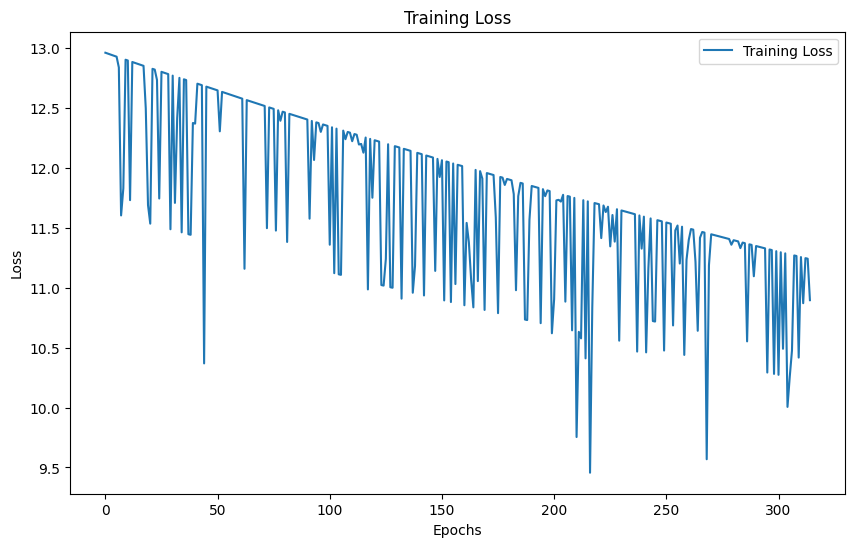

In [671]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [672]:
from sklearn.metrics import mean_squared_error, r2_score

def plot_predictions_vs_actual(predictions, actual, title='Predictions vs Actual'):
    plt.figure(figsize=(10, 6))

    val=""

    for i in range(actual.shape[1]):
        if i ==1:
            val = 'u'
        else:
            val = 'x'
        
        # print('actual: ',actual[:,i])
        # print('predicted: ',predictions[:,i])
        plt.plot(test_time[0].squeeze(0), actual[:,i], '-o',label=f'Actual Values {val}')
        plt.plot(test_time[0,:,actual.shape[0]-predictions.shape[0]:].squeeze(0),predictions[:,i],'--x', label=f'Predicted Values {val}')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    

def rmse_r2(predictions, actual, description ):
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    r_squared = r2_score(actual, predictions)

    print(f'{description} Test RMSE: {rmse}')
    print(f'{description} Test R²: {r_squared}')
    
    return rmse, r_squared
    

full test sequence tensor([[[ 0.8542,  0.9823,  1.1139,  1.2500],
         [-0.8333, -0.5079, -0.2361,  0.0000]],

        [[ 1.0617,  1.4051,  1.8253,  2.3333],
         [ 0.3750,  0.4091,  0.4500,  0.5000]],

        [[ 1.5000,  1.2857,  1.1250,  1.0000],
         [ 1.3333,  1.5556,  1.7778,  2.0000]]])
Function 1 Test RMSE: 0.0
Function 1 Test R²: 1.0


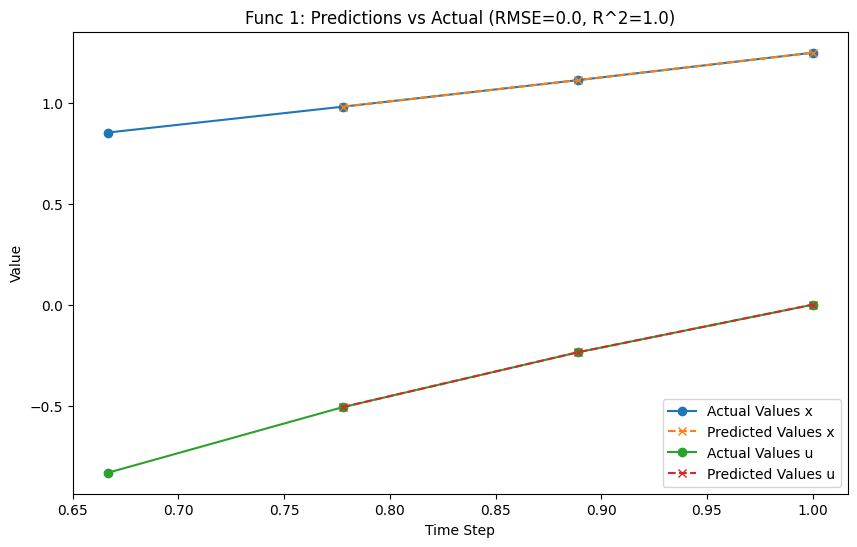

In [673]:
#Metrics function 1
test_array_tensor = torch.tensor(test_array, dtype=torch.float32)
print('full test sequence',test_array_tensor)

rmse, r_squared = rmse_r2(val_outputs[0].squeeze(0),y_test_tensor.transpose(1,2)[0,:,:], 'Function 1')
plot_predictions_vs_actual(val_outputs[0].squeeze(0),test_array_tensor.transpose(1,2)[0,:,:], f'Func 1: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})')



Function 2 Test RMSE: 0.0
Function 2 Test R²: 1.0


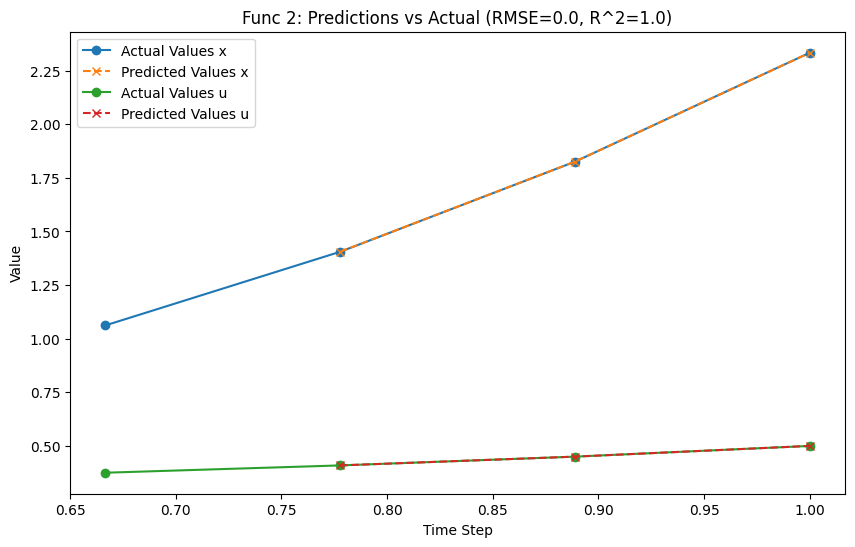

In [674]:
#Metrics function 2

rmse_r2(val_outputs[1].squeeze(0),y_test_tensor.transpose(1,2)[1,:,:], 'Function 2')
plot_predictions_vs_actual(val_outputs[1].squeeze(0),test_array_tensor.transpose(1,2)[1,:,:], f'Func 2: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})')

In [675]:
#Metrics function 3

rmse_r2(val_outputs[2].squeeze(0),y_test_tensor.transpose(1,2)[2,:,:], 'Function 3')
plot_predictions_vs_actual(val_outputs[2].squeeze(0),test_array_tensor.transpose(1,2)[2,:,:], f'Func 3: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})') #plot for x

Function 3 Test RMSE: 0.0
Function 3 Test R²: 1.0


KeyboardInterrupt: 